<a href="https://colab.research.google.com/github/nhlong1512/IS403.N21/blob/main/Final/ARIMAX_Final05052023_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

Đọc dữ liệu

In [12]:
btc_data = pd.read_csv('BTC-USD.csv')
eth_data = pd.read_csv('ETH-USD.csv')

Dữ liệu BTC-USD

In [13]:
btc_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1/1/2019,3746.713379,3850.913818,3707.231201,3843.520020,3843.520020,4.324201e+09
1,1/2/2019,3849.216309,3947.981201,3817.409424,3943.409424,3943.409424,5.244857e+09
2,1/3/2019,3931.048584,3935.685059,3826.222900,3836.741211,3836.741211,4.530215e+09
3,1/4/2019,3832.040039,3865.934570,3783.853760,3857.717529,3857.717529,4.847965e+09
4,1/5/2019,3851.973877,3904.903076,3836.900146,3845.194580,3845.194580,5.137610e+09


Dữ liệu ETH-USD

In [14]:
eth_data.head()

,Date,Close-ETH
0,1/1/2019,140.819412
1,1/2/2019,155.047684
2,1/3/2019,149.135010
3,1/4/2019,154.581940
4,1/5/2019,155.638596


Tiền xử lý dữ liệu

In [15]:
btc_data['Date'] = pd.to_datetime(btc_data['Date'])
btc_data.set_index('Date', inplace=True)
eth_data['Date'] = pd.to_datetime(eth_data['Date'])
eth_data.set_index('Date', inplace=True)

Kết hợp dữ liệu BTC và ETH

In [16]:
data = pd.merge(btc_data, eth_data, on='Date')

Chia dữ liệu 7-3

In [17]:
train_size = int(len(data) * 0.7)
train, test = data.iloc[:train_size], data.iloc[train_size:]
print(train)

                    Open          High           Low         Close  \
Date                                                                 
2019-01-01   3746.713379   3850.913818   3707.231201   3843.520020   
2019-01-02   3849.216309   3947.981201   3817.409424   3943.409424   
2019-01-03   3931.048584   3935.685059   3826.222900   3836.741211   
2019-01-04   3832.040039   3865.934570   3783.853760   3857.717529   
2019-01-05   3851.973877   3904.903076   3836.900146   3845.194580   
...                  ...           ...           ...           ...   
2021-12-16  48900.464840  49425.574220  47529.878910  47665.425780   
2021-12-17  47653.730470  48004.894530  45618.214840  46202.144530   
2021-12-18  46219.253910  47313.828130  45598.441410  46848.777340   
2021-12-19  46853.867190  48089.664060  46502.953130  46707.015630   
2021-12-20  46707.062500  47401.718750  45579.808590  46880.277340   

               Adj Close        Volume    Close-ETH  
Date                               

Chúng ta đã sử dụng hàm SARIMAX của statsmodels để huấn luyện mô hình ARIMAX. Hàm SARIMAX cho phép chúng ta chọn biến ngoại sinh bằng cách truyền tham số exog vào hàm

In [18]:
model = SARIMAX(train['Close'], exog=train['Close-ETH'], order=(1, 0, 1))
model_fit = model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


**<h3>Dự đoán</h3>**

In [19]:
exog_forecast = test['Close-ETH']
forecast = model_fit.predict(start=len(train), end=len(train)+len(test)-1, exog=exog_forecast)

Biểu đồ Plot

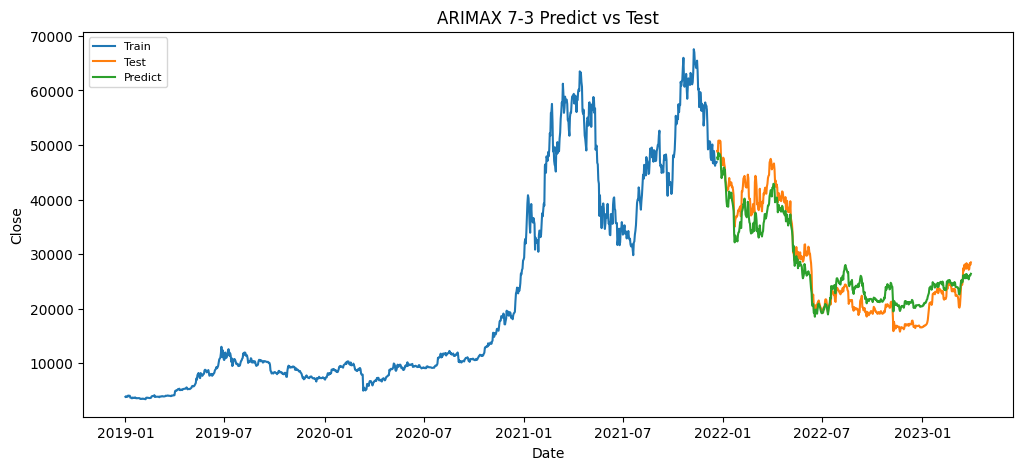

In [26]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train['Close'], label='Train')
plt.plot(test['Close'], label='Test')
plt.plot(forecast, label='Predict')
plt.ylabel('Close');
plt.xlabel('Date');
plt.title('ARIMAX 7-3 Predict vs Test')
plt.legend(loc='upper left', fontsize=8)
plt.show()

Tính toán mô hình ARIMAX 7-3

In [27]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 
            'corr':corr, 'minmax':minmax})

forecast_accuracy(forecast, test.Close)

<ipython-input-27-aaa5dbf177dd>:8: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mins = np.amin(np.hstack([forecast[:,None],
<ipython-input-27-aaa5dbf177dd>:9: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)
<ipython-input-27-aaa5dbf177dd>:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  maxs = np.amax(np.hstack([forecast[:,None],
<ipython-input-27-aaa5dbf177dd>:11: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:

{'mape': 0.11002521830759507,
 'me': 107.01055629038459,
 'mae': 2754.0658193467325,
 'mpe': 0.03910418857292712,
 'rmse': 3095.854732187642,
 'corr': 0.976816429236809,
 'minmax': 0.09889747814522032}